In [1]:
INSTANCE_ID = open("INSTANCE_ID").read()

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType, CustomUrlParam
from sentinelhub.common import BBox, CRS # Different than in examples
from sentinelhub import CustomUrlParam

from s2cloudless import S2PixelCloudDetector
from s2cloudless import CloudMaskRequest

/Users/joosko/work/ijs/ml/SentinelHub/venv/lib/python3.6/site-packages/tifffile/tifffile.py:7685: UserWarning: No module named 'tifffile._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))


In [49]:
import datetime
end_time = datetime.datetime.now().strftime('%Y-%m-%d')
start_time = '2014-12-01'

bbox_coords_wgs84 = [14.419052876760505, -90.92164993286133, 14.55201636533031, -90.81865310668945]
fmf_box = [45.9,14.4, 46.0,14.6]
slovenia_box= (45.4523163926,13.6981099789,46.8523859727, 16.5648083839, )
fmf_box = BBox(bbox=slovenia_box, crs=CRS.WGS84)

def plot_cloud_mask(mask, figsize=(15,15), cmap="gray", normalize=False, plot_cmap=False):
    """
    Utility function for plotting a binary cloud mask.
    """
    plt.figure()
    plt.tight_layout()
    plot = plt.subplot(1, 1, 1)
    # Otherwise image cmap is normalized to [min(data), max(data)]  
    if not normalize:
        vmin_vmax = {"vmin":0, "vmax":1}
    else:
        vmin_vmax = dict()
    im = plot.imshow(mask, cmap=cmap, **vmin_vmax)
    if plot_cmap:
        plt.colorbar(im)
    
def overlay_cloud_mask(image, mask=None, factor=1./255, nrows=1, ncols=1, figsize=(15, 15)):
    """
    Utility function for plotting RGB images with binary mask overlayed. The numpy arrays returned 
    by the Sentinel Hub's WMS and WCS requests have channels ordered as Blue (`B02`), Green (`B03`), 
    and Red (`B04`) therefore the order has to be reversed before ploting the image.
    """
    plt.subplots(nrows, ncols, figsize=figsize, frameon=False)
    rgb = np.zeros(image.shape, dtype=np.uint8)
    rgb = image[..., [2, 1, 0]]

    plt.imshow(rgb * factor)
    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
        cloud_image[mask == 1] = np.asarray([255,255,0,100], dtype=np.uint8)
        plt.imshow(cloud_image)
def plot_previews(data, dates, cols = 4):
    """
    Utility to plot small "true color" previews.
    """
    rows = data.shape[0]//cols + (1 if data.shape[0]%cols else 0)
    fig, axs = plt.subplots(nrows=rows,ncols=cols,figsize=(15,15*rows*0.6))
    for index, ax in enumerate(axs.flatten()):
        if index < data.shape[0]:
            caption = str(index)+': '+dates[index].strftime('%Y-%m-%d')
            ax.set_axis_off()
            ax.imshow(data[index][..., [2, 1, 0]]/255., vmin=0.0, vmax=1.0)
            ax.text(0, -2, caption, fontsize=12, color='g')
        else:
            ax.set_axis_off()

def get_image_mask(img):
    return (img == 255).all(axis=2)

In [4]:
bands_script = 'return [B01,B02,B04,B05,B08,B8A,B09,B10,B11,B12]'


wms_true_color_request = WmsRequest(layer='TRUE_COLOR',
                                    bbox=fmf_box, data_folder='data2/',
                                    time=(start_time, end_time), 
                                    width=200,
                                    image_format=MimeType.PNG,
                                    instance_id=INSTANCE_ID, 
                                    custom_url_params={CustomUrlParam.SHOWLOGO: False,},
                                   )

# Note: large widths are much much slower and more computationally expensive
wms_bands_request = WmsRequest(layer='TRUE_COLOR', data_folder='data2/',
                                  custom_url_params={CustomUrlParam.EVALSCRIPT: bands_script, CustomUrlParam.SHOWLOGO: False},
                                  bbox=fmf_box,
                                  time=(start_time, end_time), 
                                  width=200,
                                  image_format=MimeType.TIFF_d32f,
                                  instance_id=INSTANCE_ID)

wms_bands = wms_bands_request.save_data()
wms_true_color = wms_true_color_request.save_data()

INFO:sentinelhub.data_request:The data is available in folder data2
INFO:sentinelhub.data_request:The data is available in folder data2


In [5]:
wms_bands = wms_bands_request.get_data()
wms_true_color_imgs = wms_true_color_request.get_data()

In [6]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

In [ ]:
# Create cloud masks (could take long time)
cloud_masks = cloud_detector.get_cloud_masks(np.array(wms_bands))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int8)

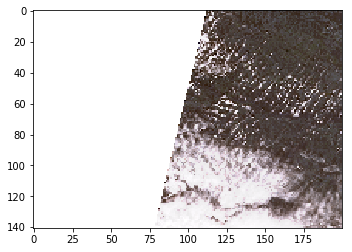

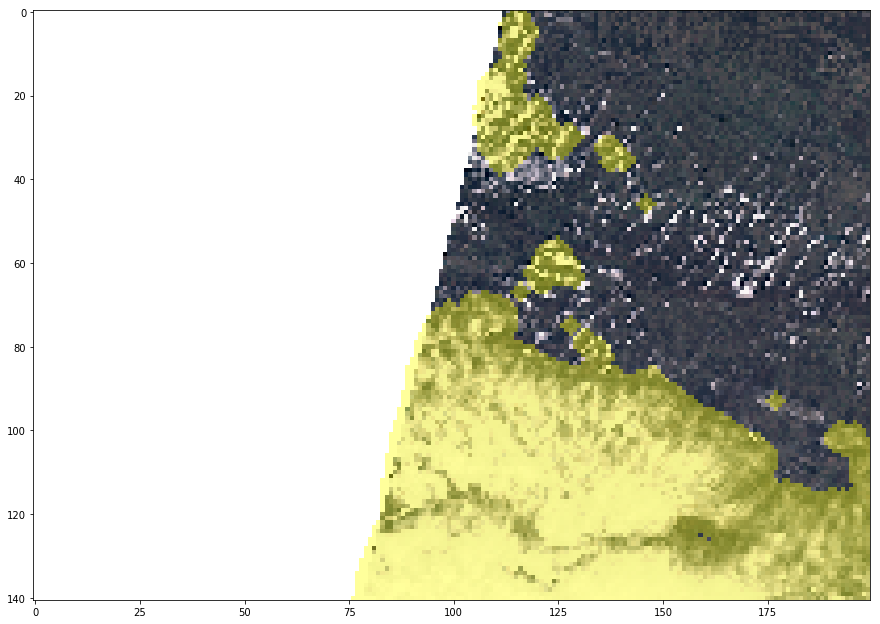

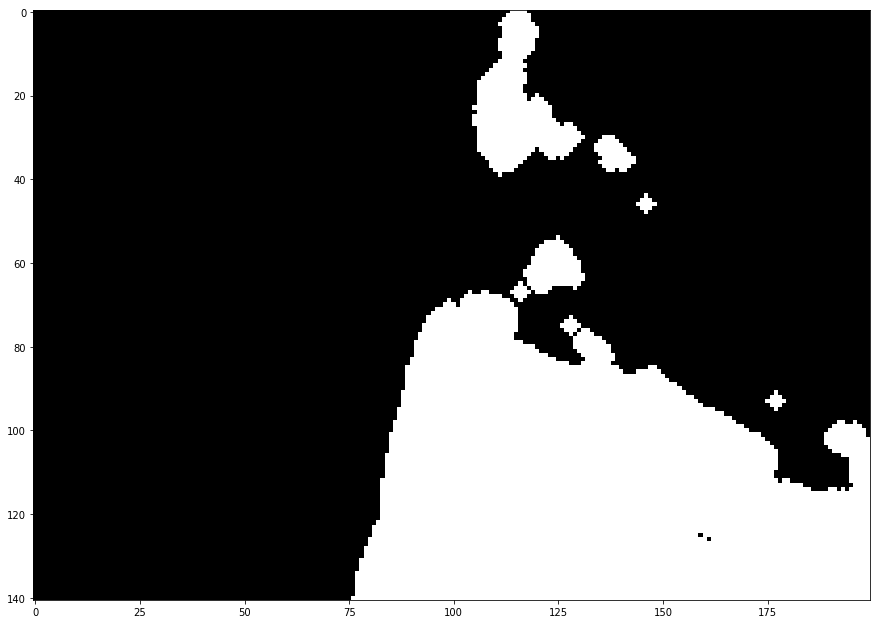

In [8]:
# Sample image with cloud classification, beware, due to tiling, some pixels are white (not photographed)
image_idx = 52
plt.imshow(wms_true_color_imgs[image_idx])
overlay_cloud_mask(wms_true_color_imgs[image_idx], cloud_masks[image_idx])
plot_cloud_mask(cloud_masks[image_idx])
cloud_masks[image_idx]

[[0.20116618 0.19825073 0.20699708 ... 0.20116618 0.19825073 0.19533528]
 [0.20116618 0.20699708 0.20408163 ... 0.20116618 0.19825073 0.19533528]
 [0.20699708 0.20699708 0.20699708 ... 0.19825073 0.19533528 0.18950437]
 ...
 [0.08163265 0.0845481  0.08163265 ... 0.10495627 0.10204082 0.10204082]
 [0.0787172  0.08163265 0.0787172  ... 0.10495627 0.10204082 0.10204082]
 [0.07580175 0.0787172  0.0787172  ... 0.10495627 0.10204082 0.10204082]]


AttributeError: 'AxesSubplot' object has no attribute 'tight_layout'

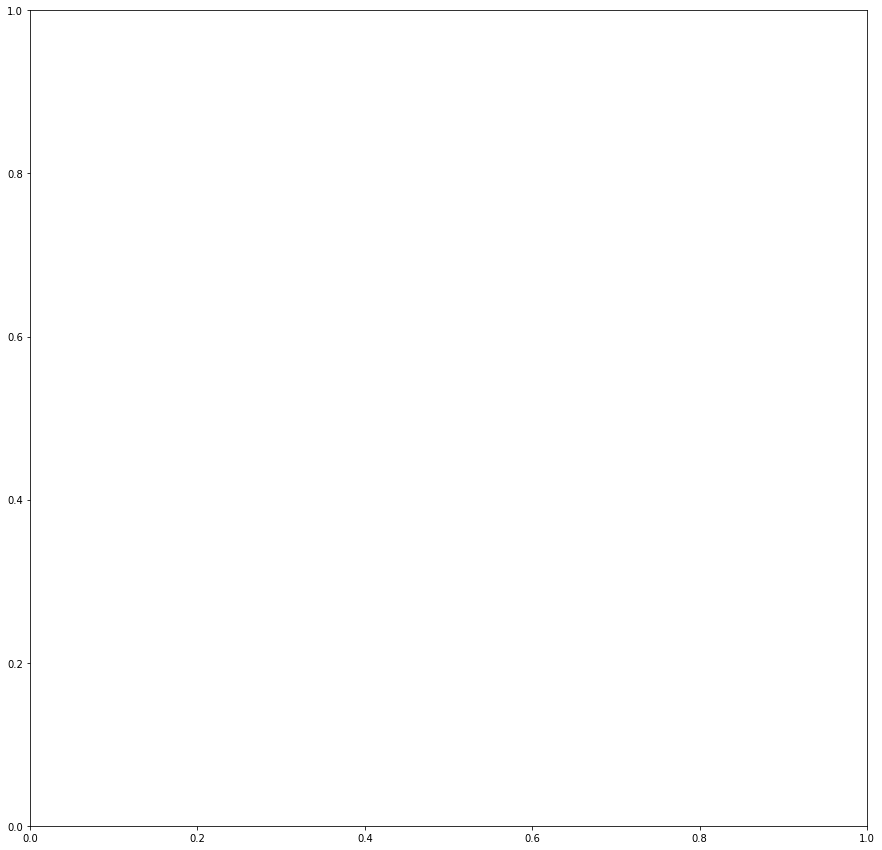

In [50]:
# Average image masks
# TODO: divide by active masks only
total_mask = (sum(cloud_masks) / len(cloud_masks)).astype(float)
print(total_mask)
# Plot them in ranbow color map
plot_cloud_mask(total_mask,cmap="rainbow", plot_cmap=1)
plt.savefig("cloud_gradient_unfiltered.png")
plot_cloud_mask(total_mask)

# Red band: many clouds
# Blue band: No cloud
# Tiling problem: some tiles are counted more times
# TODO: do not count tile multiple times and account for borders

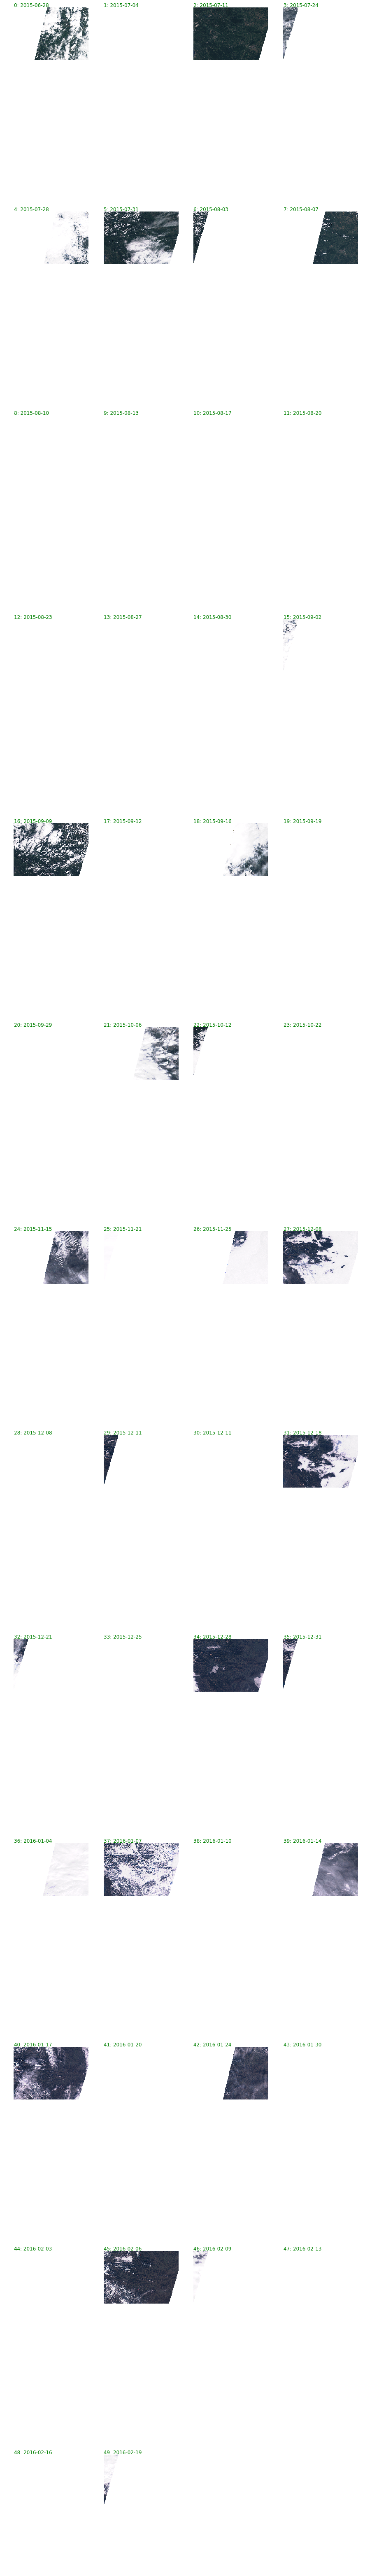

In [10]:
# Sanity check
# examine some images by hand
plot_previews(np.asarray(wms_true_color_imgs[:50]), wms_true_color_request.get_dates(), cols=4)

array([[0.20116618, 0.19825073, 0.20699708, ..., 0.20116618, 0.19825073,
        0.19533528],
       [0.20116618, 0.20699708, 0.20408163, ..., 0.20116618, 0.19825073,
        0.19533528],
       [0.20699708, 0.20699708, 0.20699708, ..., 0.19825073, 0.19533528,
        0.18950437],
       ...,
       [0.08163265, 0.0845481 , 0.08163265, ..., 0.10495627, 0.10204082,
        0.10204082],
       [0.0787172 , 0.08163265, 0.0787172 , ..., 0.10495627, 0.10204082,
        0.10204082],
       [0.07580175, 0.0787172 , 0.0787172 , ..., 0.10495627, 0.10204082,
        0.10204082]])

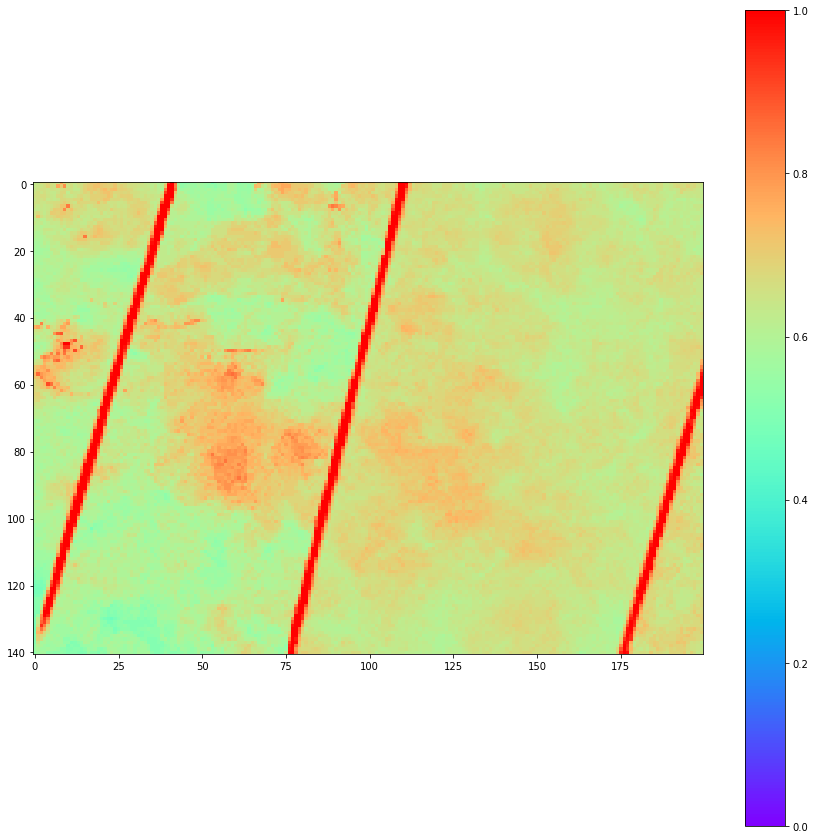

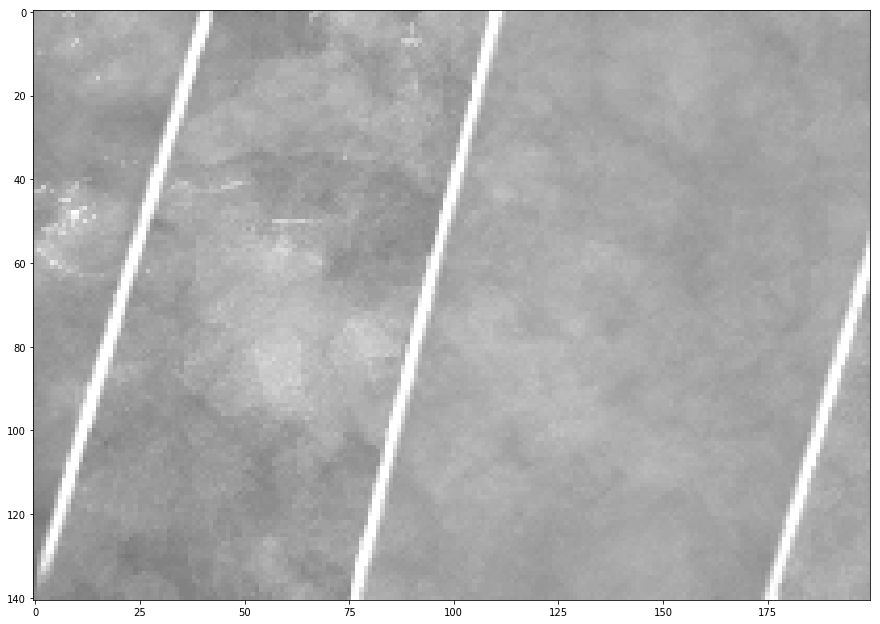

In [33]:
# First idea for image detection:
# Extract full white pixels and treat them as non image 
# Warning: it does detect some clouds, but mostly works ok
off_image_detection_mask = sum(map(get_image_mask, wms_true_color_imgs)) # Just sum how many times we detect white pixels
full_cloud_mask = sum(cloud_masks)
# Get total mask by dividing number of cloud detections by number of all sensible pixels
total_mask_w = (full_cloud_mask / (len(cloud_masks) - off_image_detection_mask)).astype(float)
# t_m_w[i][j] percentage of clouds detected in pixel i,j 
# 1 -> 100% percent cloudy
# 0 -> no clouds

# Plot them in ranbow color map
# Red band: many clouds
# Blue band: No cloud
plot_cloud_mask(total_mask_w,cmap="rainbow", plot_cmap=True)
plt.savefig("cloud_gradient_filtered.png")
plot_cloud_mask(total_mask_w)
total_mask


[[0.63302752 0.62962963 0.66981132 ... 0.67647059 0.66019417 0.65048544]
 [0.63302752 0.64545455 0.64814815 ... 0.67647059 0.65384615 0.63809524]
 [0.63963964 0.65137615 0.65740741 ... 0.65384615 0.64423077 0.625     ]
 ...
 [0.53846154 0.60416667 0.58333333 ... 0.65454545 0.64814815 0.64814815]
 [0.55102041 0.58333333 0.5625     ... 0.65454545 0.64814815 0.63636364]
 [0.54166667 0.5625     0.57446809 ... 0.66666667 0.63636364 0.64814815]]


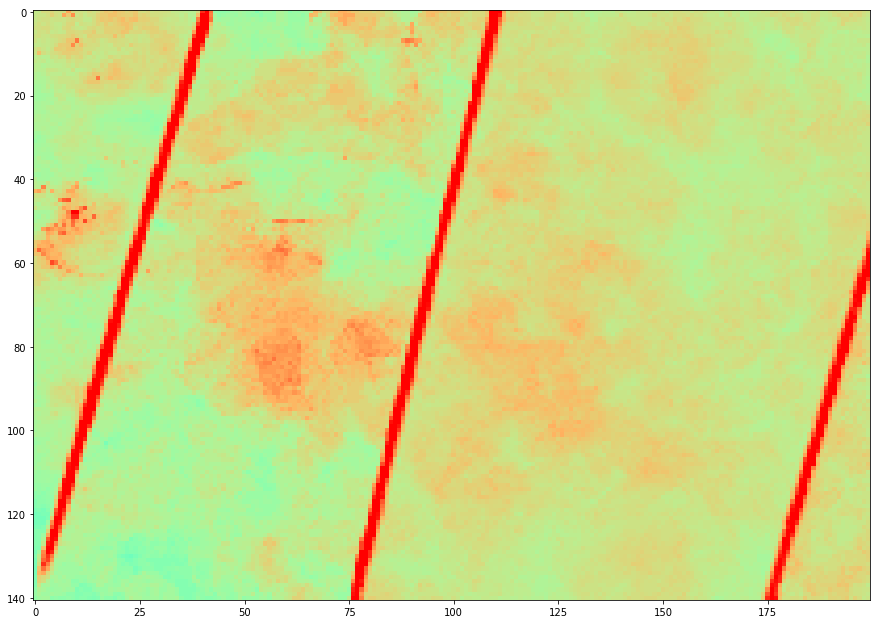

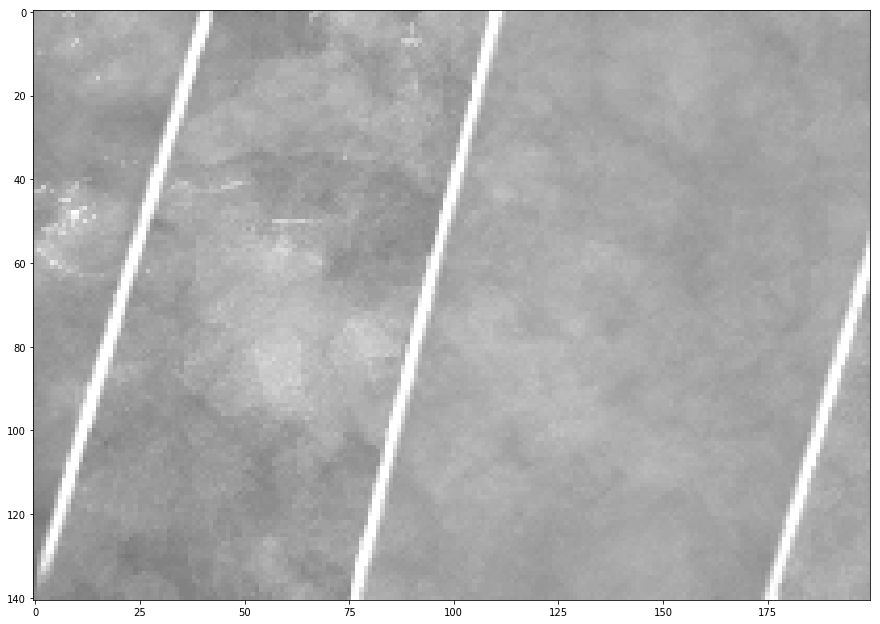

In [12]:
# First idea for image detection:
# Extract full white pixels and treat them as non image 
# Warning: it does detect some clouds, but mostly works ok
total_mask_weighted = (sum(cloud_masks) / (len(cloud_masks) - sum(map(get_image_mask, wms_true_color_imgs)) )).astype(float)
# t_m_w[i][j] percentage of clouds detected in pixel i,j 
# 1 -> 100% percent cloudy
# 0 -> no clouds
# Plot them in ranbow color map
print(total_mask_weighted)
plot_cloud_mask(total_mask_weighted,cmap="rainbow")
plot_cloud_mask(total_mask_weighted)

In [13]:
tulips_coords = (52.89906593845727, 4.71038818359375,52.95205098150524, 4.798278808593751)
# Coordinates for Atacama desert -> they give much less cloudy image
# tulips_coords = [-23.8634, -69.1328, -22.0, -68.6]
tulips_bbox = BBox(bbox=tulips_coords, crs=CRS.WGS84)

In [14]:
# Note: large widths are much much slower and more computationally expensive
bands_script = 'return [B01,B02,B04,B05,B08,B8A,B09,B10,B11,B12]'


wms_true_color_request_tulips = WmsRequest(layer='TRUE_COLOR',
                                    bbox=tulips_bbox, data_folder='data2/',
                                    time=(start_time, end_time), 
                                    width=200,
                                    image_format=MimeType.PNG,
                                    instance_id=INSTANCE_ID, 
                                    custom_url_params={CustomUrlParam.SHOWLOGO: False,},
                                   )

# Note: large widths are much much slower and more computationally expensive
wms_bands_request_tulips = WmsRequest(layer='TRUE_COLOR', data_folder='data2/',
                                  custom_url_params={CustomUrlParam.EVALSCRIPT: bands_script, CustomUrlParam.SHOWLOGO: False},
                                  bbox=tulips_bbox,
                                  time=(start_time, end_time), 
                                  width=200,
                                  image_format=MimeType.TIFF_d32f,
                                  instance_id=INSTANCE_ID)

wms_bands_tulips = wms_bands_request_tulips.save_data()
wms_true_color_tulips = wms_true_color_request_tulips.save_data()

INFO:sentinelhub.data_request:The data is available in folder data2
INFO:sentinelhub.data_request:The data is available in folder data2


In [15]:
wms_bands_tulips = wms_bands_request_tulips.get_data()
wms_true_color_imgs_tulips = wms_true_color_request_tulips.get_data()

In [16]:
# Create cloud masks (could take long time)
cloud_masks_tulips = cloud_detector.get_cloud_masks(np.array(wms_bands_tulips))

array([[0.59459459, 0.6036036 , 0.6036036 , ..., 0.68807339, 0.68468468,
        0.67272727],
       [0.61261261, 0.60909091, 0.6036036 , ..., 0.70642202, 0.69090909,
        0.69090909],
       [0.61261261, 0.61261261, 0.6036036 , ..., 0.70642202, 0.7       ,
        0.70909091],
       ...,
       [0.63636364, 0.63636364, 0.64545455, ..., 0.69642857, 0.7027027 ,
        0.7027027 ],
       [0.63636364, 0.63636364, 0.63636364, ..., 0.7       , 0.70909091,
        0.7       ],
       [0.63636364, 0.63636364, 0.63636364, ..., 0.70909091, 0.70909091,
        0.7       ]])

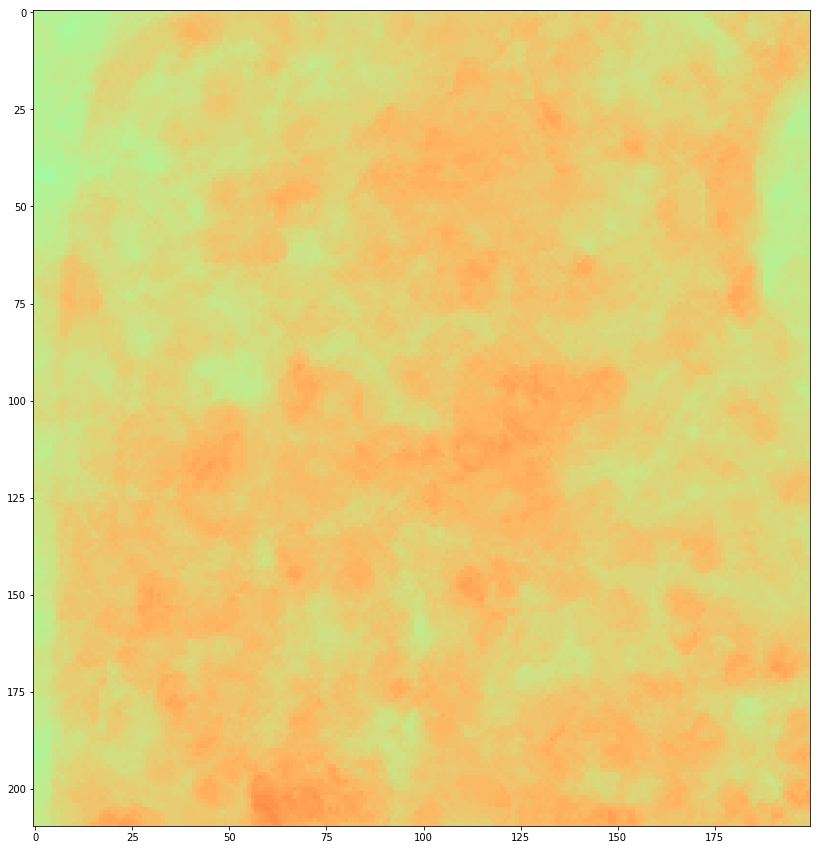

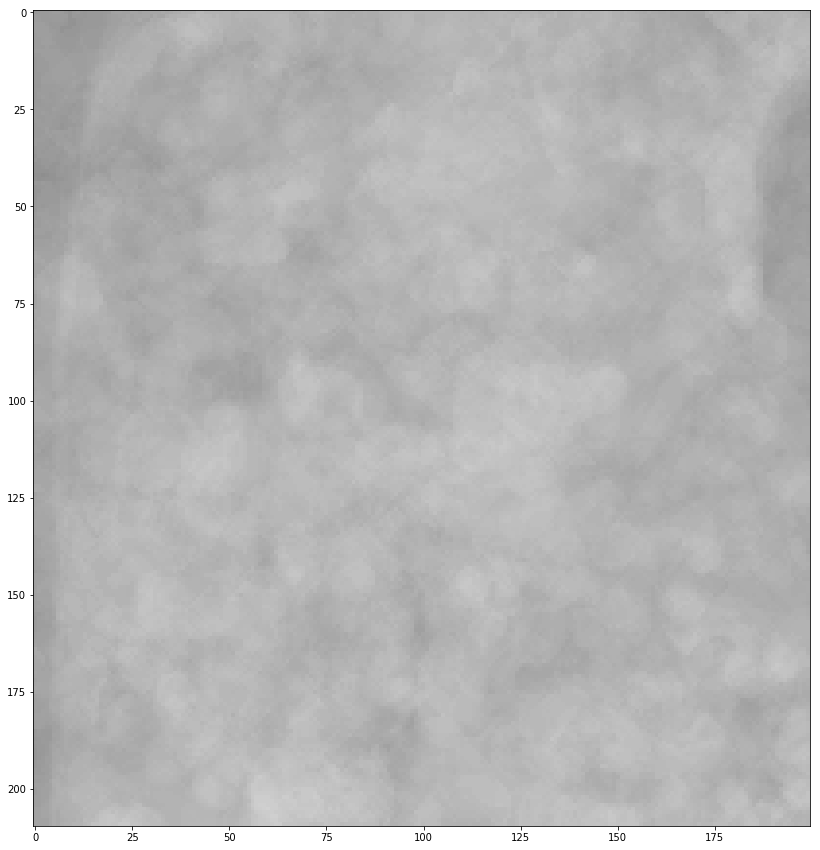

In [17]:
# First idea for image detection:
# Extract full white pixels and treat them as non image 
# Warning: it does detect some clouds, but mostly works ok
off_image_detection_mask_tulips = sum(map(get_image_mask, wms_true_color_imgs_tulips)) # Just sum how many times we detect white pixels
full_cloud_mask_tulips = sum(cloud_masks_tulips)
# Get total mask by dividing number of cloud detections by number of all sensible pixels
total_mask_w_t = (full_cloud_mask_tulips / (len(cloud_masks_tulips) - off_image_detection_mask_tulips)).astype(float)
# t_m_w[i][j] percentage of clouds detected in pixel i,j 
# 1 -> 100% percent cloudy
# 0 -> no clouds

# Plot them in ranbow color map
# Red band: many clouds
# Blue band: No cloud
plot_cloud_mask(total_mask_w_t,cmap="rainbow")
# white: many clouds
# Black: no clouds
plot_cloud_mask(total_mask_w_t)
total_mask_w_t
